In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from minepy import MINE
from scipy.stats import pearsonr,spearmanr, describe, shapiro, normaltest, bartlett, levene, f_oneway, ttest_ind, ranksums, kruskal, mannwhitneyu,anderson,t,ttest_rel
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.graphics import gofplots
import copy
import dcor
import warnings
warnings.filterwarnings('ignore')
sns.set()

____________________________________________________________________________________________________

# Correlation coefficients

### Pearson correlation coefficient

A measure of the linear correlation between two variables X and Y.  It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

$$
\rho_{X, Y}=\frac{\operatorname{cov}(X, Y)}{\sigma_{X} \sigma_{Y}}
$$

In [8]:
np.random.seed(1077939816)
sample_size = 100
noise_mean = 0
noise_std = 1

theta = np.random.randn(2)
x_1 = np.random.randn(sample_size)*10
y_1 = theta[0]*x_1+theta[1]
y_1_noise = y_1 + np.random.normal(noise_mean,noise_std,size = sample_size).T

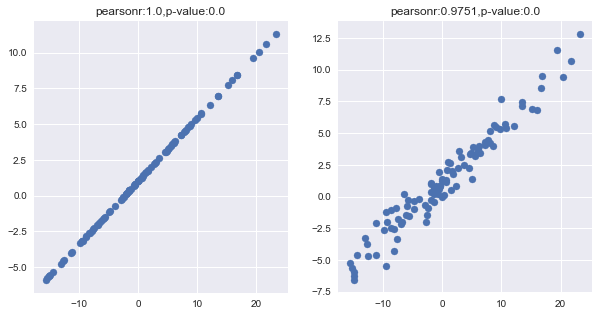

In [9]:
ro_1, p_1 = pearsonr(x_1,y_1)
ro_2, p_2 = pearsonr(x_1,y_1_noise)
fig, axs = plt.subplots(nrows=1, ncols=2,figsize = (10,5))
axs.flat[0].scatter(x_1,y_1)
axs.flat[0].set_title("pearsonr:{0},p-value:{1}".format(np.round(ro_1,4),np.round(p_1,4)))
axs.flat[1].scatter(x_1,y_1_noise)
axs.flat[1].set_title("pearsonr:{0},p-value:{1}".format(np.round(ro_2,4),np.round(p_2,4)));

In [10]:
np.random.seed(15)

x_2 = np.random.rand(sample_size)*5
y_2_cuadr = x_2**2 + np.random.normal(noise_mean,noise_std,size = sample_size)
y_2_sin = np.sin(x_2) + np.random.normal(noise_mean,noise_std,size = sample_size)
y_2_log = np.log(x_2) + np.random.normal(noise_mean,noise_std-0.5,size = sample_size)

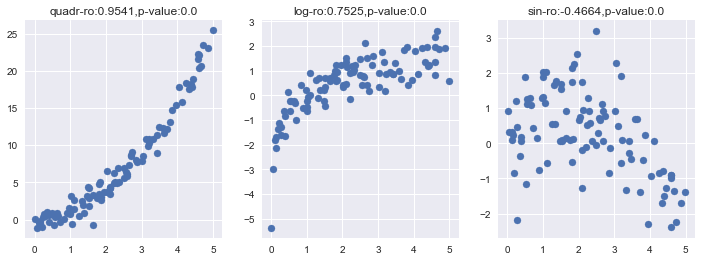

In [11]:
ro_0, p_0 = pearsonr(x_2,y_2_cuadr)
ro_1, p_1 = pearsonr(x_2,y_2_log)
ro_2, p_2 = pearsonr(x_2,y_2_sin)
fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (12,4))
axs.flat[0].scatter(x_2,y_2_cuadr)
axs.flat[0].set_title("quadr-ro:{0},p-value:{1}".format(np.round(ro_0,4),np.round(p_0,4)))
axs.flat[1].scatter(x_2,y_2_log)
axs.flat[1].set_title("log-ro:{0},p-value:{1}".format(np.round(ro_1,4),np.round(p_1,4)))
axs.flat[2].scatter(x_2,y_2_sin);
axs.flat[2].set_title("sin-ro:{0},p-value:{1}".format(np.round(ro_2,4),np.round(p_2,4)));

### Spearman's rank correlation coefficient

A measure of rank correlation (statistical dependence between the rankings of two variables).It assesses how well the relationship between two variables can be described using a monotonic function. The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not).

$$r_{s}=\rho_{\mathrm{rg} x, \mathrm{rg}_{Y}}=\frac{\operatorname{cov}\left(\mathrm{rg}_{X}, \mathrm{rg}_{Y}\right)}{\sigma_{\mathrm{rg}_{X}} \sigma_{\mathrm{rg}_{Y}}}$$

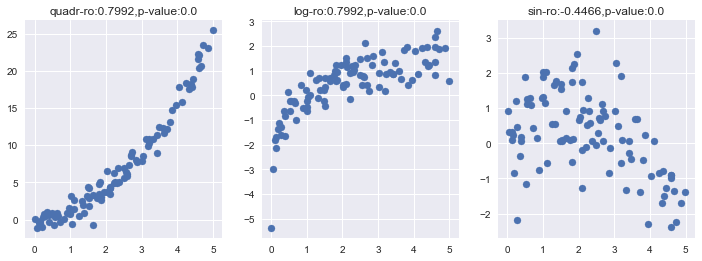

In [12]:
ro_0, p_0 = spearmanr(x_2,y_2_log)
ro_1, p_1 = spearmanr(x_2,y_2_log)
ro_2, p_2 = spearmanr(x_2,y_2_sin)

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (12,4))

axs.flat[0].scatter(x_2,y_2_cuadr)
axs.flat[0].set_title("quadr-ro:{0},p-value:{1}".format(np.round(ro_0,4),np.round(p_0,4)))
axs.flat[1].scatter(x_2,y_2_log)
axs.flat[1].set_title("log-ro:{0},p-value:{1}".format(np.round(ro_1,4),np.round(p_1,4)))
axs.flat[2].scatter(x_2,y_2_sin);
axs.flat[2].set_title("sin-ro:{0},p-value:{1}".format(np.round(ro_2,4),np.round(p_2,4)));

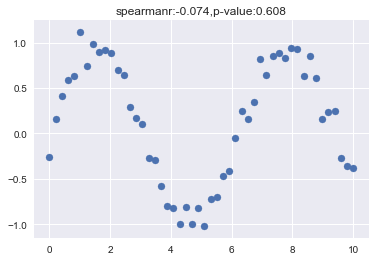

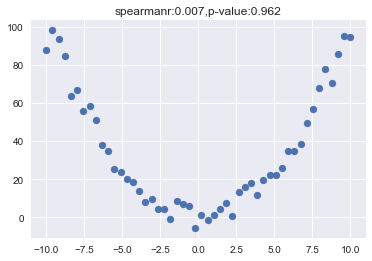

In [13]:
x = np.linspace(0,10)
y = np.sin(x) + np.random.normal(0,0.1,50)
r, p = spearmanr(x,y)
plt.scatter(x,y)
plt.title("spearmanr:{0},p-value:{1}".format(np.round(r,3),np.round(p,3)));
plt.show()

x = np.linspace(-10,10)
y = x**2 + np.random.normal(0,5,50)
r, p = spearmanr(x,y)
plt.scatter(x,y)
plt.title("spearmanr:{0},p-value:{1}".format(np.round(r,3),np.round(p,3)));

### Distance correlation

A measure of dependence between two paired random vectors of arbitrary, not necessarily equal, dimension. The population distance correlation coefficient is zero if and only if the random vectors are independent. Thus, distance correlation measures both linear and nonlinear association between two random variables or random vectors.

$$\operatorname{dCor}(X, Y)=\frac{\operatorname{dCov}(X, Y)}{\sqrt{\operatorname{dVar}(X) \mathrm{d} \operatorname{Var}(Y)}}$$

The distance correlation is derived from a number of other quantities that are used in its specification, specifically: distance variance, distance standard deviation, and distance covariance. Check [this](https://en.wikipedia.org/wiki/Distance_correlation).

In [14]:
def distcorr(Xval, Yval, pval=True, nruns=2000):
    """ Compute the distance correlation function, returning the p-value.
    Based on Satra/distcorr.py (gist aa3d19a12b74e9ab7941)
    >>> a = [1,2,3,4,5]
    >>> b = np.array([1,2,9,4,4])
    >>> distcorr(a, b)
    (0.76267624241686671, 0.404)
    """
    X = np.atleast_1d(Xval)
    Y = np.atleast_1d(Yval)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum() / float(n * n)
    dcov2_xx = (A * A).sum() / float(n * n)
    dcov2_yy = (B * B).sum() / float(n * n)
    dcor = np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))

    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Yval)
            np.random.shuffle(Y_r)
            if distcorr(Xval, Y_r, pval=False) >= dcor:
                greater += 1
        return (dcor, greater / float(nruns))
    else:
        return dcor

def dist_corr(X, Y, pval=True, nruns=2000):
    """ Distance correlation with p-value from bootstrapping
    """
    dc = dcor.distance_correlation(X, Y)
    pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]
    if pval:
        return (dc, pv)
    else:
        return dc

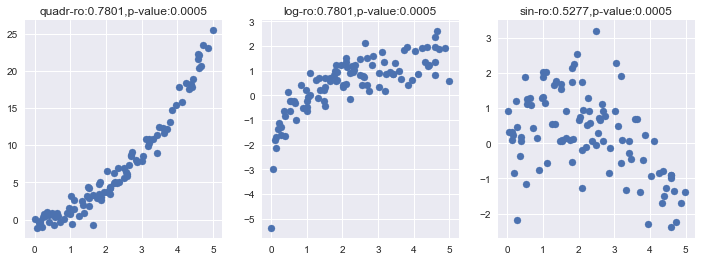

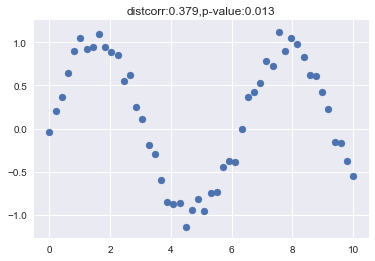

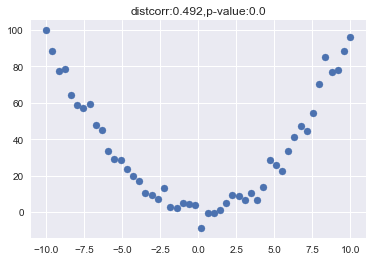

In [15]:
ro_0, p_0 = dist_corr(x_2,y_2_log)
ro_1, p_1 = dist_corr(x_2,y_2_log)
ro_2, p_2 = dist_corr(x_2,y_2_sin)
fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (12,4))
axs.flat[0].scatter(x_2,y_2_cuadr)
axs.flat[0].set_title("quadr-ro:{0},p-value:{1}".format(np.round(ro_0,4),np.round(p_0,4)))
axs.flat[1].scatter(x_2,y_2_log)
axs.flat[1].set_title("log-ro:{0},p-value:{1}".format(np.round(ro_1,4),np.round(p_1,4)))
axs.flat[2].scatter(x_2,y_2_sin);
axs.flat[2].set_title("sin-ro:{0},p-value:{1}".format(np.round(ro_2,4),np.round(p_2,4)))
plt.show()
x = np.linspace(0,10)
y = np.sin(x) + np.random.normal(0,0.1,50)
r, p = dist_corr(x,y)
plt.scatter(x,y)
plt.title("distcorr:{0},p-value:{1}".format(np.round(r,3),np.round(p,3)));
plt.show()

x = np.linspace(-10,10)
y = x**2 + np.random.normal(0,5,50)
r, p = dist_corr(x,y)
plt.scatter(x,y)
plt.title("distcorr:{0},p-value:{1}".format(np.round(r,3),np.round(p,3)));

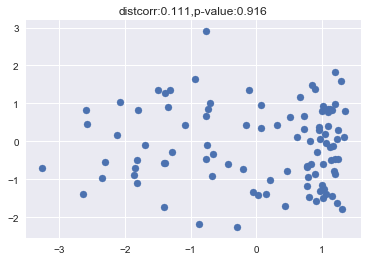

In [16]:
from sklearn.datasets import make_classification
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1)
d,p = dist_corr(X1[:,0],X1[:,1])
plt.scatter(X1[:,0],X1[:,1])
plt.title("distcorr:{0},p-value:{1}".format(np.round(d,3),np.round(p,3)));

### Maximal information coefficient

A measure of the strength of the linear or non-linear association between two variables X and Y. 

MIC(X,Y) is the mutual information between random variables X and Y normalized by their minimum joint entropy. 

$$
M I C(x, y)=\max \left\{I(x, y) / \log _{2} \min \mathrm{H}(X, Y)\right\}
$$

Mutual Information:
$$
I(X ; Y)=D_{\mathrm{KL}}\left(P_{(X, Y)} \| P_{X} \otimes P_{Y}\right)
$$
The mutual information of two jointly discrete random variables X and Y:
$$
\mathrm{I}(X ; Y)=\sum_{y \in y} \sum_{x \in \mathcal{X}} p_{(X, Y)}(x, y) \log \left(\frac{p_{(X, Y)}(x, y)}{p_{X}(x) p_{Y}(y)}\right)
$$
In the case of jointly continuous random variables:
$$
\mathrm{I}(X ; Y)=\int_{y} \int_{\mathcal{X}} p_{(X, Y)}(x, y) \log \left(\frac{p_{(X, Y)}(x, y)}{p_{X}(x) p_{Y}(y)}\right)
$$

Joint Entropy:
$$
\mathrm{H}(X, Y)=-\sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} P(x, y) \log _{2}[P(x, y)]
$$

In [17]:
def mic(X,Y,pval=True,nruns=100):
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(X,Y)
    mic = mine.mic()
    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Y)
            np.random.shuffle(Y_r)
            mine.compute_score(X,Y_r)
            cur_mine = mine.mic()
            if cur_mine >= mic:
                greater += 1
        return (mic, greater / float(nruns))
    else:
        return mic

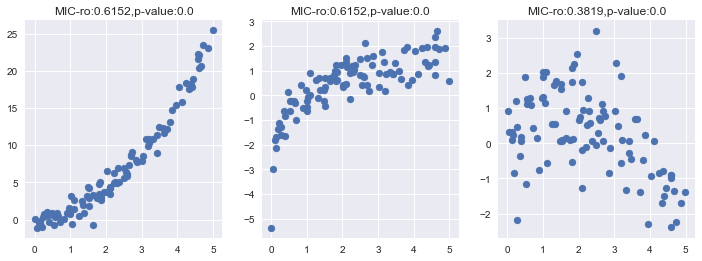

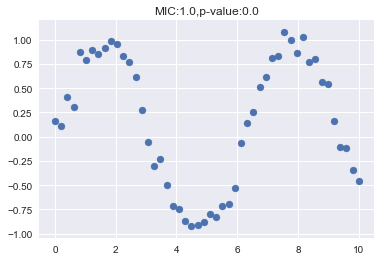

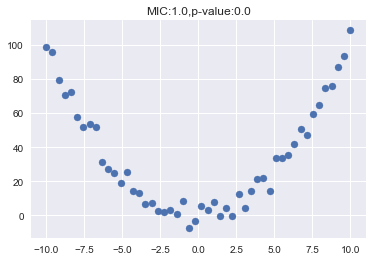

In [18]:
ro_0, p_0 = mic(x_2,y_2_log)
ro_1, p_1 = mic(x_2,y_2_log)
ro_2, p_2 = mic(x_2,y_2_sin)
fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (12,4))
axs.flat[0].scatter(x_2,y_2_cuadr)
axs.flat[0].set_title("MIC-ro:{0},p-value:{1}".format(np.round(ro_0,4),np.round(p_0,4)))
axs.flat[1].scatter(x_2,y_2_log)
axs.flat[1].set_title("MIC-ro:{0},p-value:{1}".format(np.round(ro_1,4),np.round(p_1,4)))
axs.flat[2].scatter(x_2,y_2_sin);
axs.flat[2].set_title("MIC-ro:{0},p-value:{1}".format(np.round(ro_2,4),np.round(p_2,4)))
plt.show()
x = np.linspace(0,10)
y = np.sin(x) + np.random.normal(0,0.1,50)
r, p = mic(x,y)
plt.scatter(x,y)
plt.title("MIC:{0},p-value:{1}".format(np.round(r,3),np.round(p,3)));
plt.show()

x = np.linspace(-10,10)
y = x**2 + np.random.normal(0,5,50)
r, p = mic(x,y)
plt.scatter(x,y)
plt.title("MIC:{0},p-value:{1}".format(np.round(r,3),np.round(p,3)));

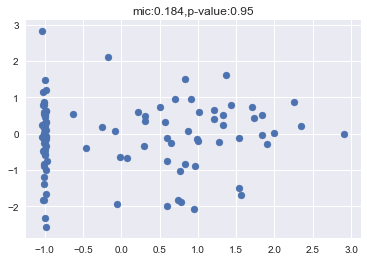

In [19]:
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1)
d,p = mic(X1[:,0],X1[:,1])
plt.scatter(X1[:,0],X1[:,1])
plt.title("mic:{0},p-value:{1}".format(np.round(d,3),np.round(p,3)));

__________________________________________________________

# Statistical Tests

A __null hypothesis__, proposes that no significant difference exists in a set of given observations.For rejecting a null hypothesis, a test statistic is calculated. <br>
A __critical value__ is a point (or points) on the scale of the test statistic beyond which we reject the null hypothesis, and, is derived from the level of significance α of the test. <br>
__P-value__ is defined as the probability of respective statistic.

##### If the test statistic is lower than the critical value, accept the hypothesis or else reject the hypothesis.

### Normality Tests

Test whether a data sample has a Gaussian distribution: Shapiro-Wilk Test, D'Agostino's K-squared test, Anderson-Darling Test, Jarque–Bera test.

The SW test has good power properties over a wide range of asymmetric distributions. If the distribution is suspected to be asymmetric (i.e. skewed) then the SW test is the best test followed closely by the AD test. If the distribution is symmetric with low kurtosis values (i.e. symmetric short-tailed distribution), then the D'Agostino and SW tests have good power. For symmetric distribution with high sample kurtosis (symmetric long-tailed), the JB, SW or AD tests can be used. 

In [22]:
def normality_test(data, alpha=0.05):

    # print col describe
    print("Data describe","\n")
    print(describe(data),"\n")
    # drop nans and duplicates
    # dist plot and qqplot

    # plot col distplot
    sns.distplot(data).set_title("DistPlot for data")
    plt.show()
    # qq plot
    gofplots.qqplot(data, line='45', fit=True)
    plt.title('Q-Q plot for data')
    plt.show()
    # Shapiro-Wilk test
    print('Shapiro-Wilk Test')
    stat, p = shapiro(data)
    if p > alpha:
        print('Accept Ho: Distribution is normal (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho: Distribution is not normal (alpha = {0})'.format(alpha))
    print('P_value: ', p,'\n')

    # D’Agostino’s K^2 Test (tests Skewness and Kurtosis)
    print('D’Agostino’s Test')
    stat, p = normaltest(data)
    if p > alpha:
        print('Accept Ho: Distribution is normal (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho: Distribution is not normal (alpha = {0})'.format(alpha))
    print('P_value: ', p,'\n')
    
    #Anderson DArling Tests
    print('Anderson-Darling Test')
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, Accept Ho: Distribution is normal' % (sl, cv))
        else:
            print('%.3f: %.3f, Reject Ho: Distribution is not normal (reject H0)' % (sl, cv))

    print('======================================================================')

In [23]:
np.random.seed(45)
sample_size = 1000
normal_data = np.random.normal(0,1,size=sample_size)
uniform_data = np.random.uniform(0,10,sample_size)

Data describe 

DescribeResult(nobs=1000, minmax=(-3.0961618865256653, 3.102025515086537), mean=-0.030285838398579693, variance=0.9821897292620424, skewness=0.008366932935316406, kurtosis=0.0036639365763813103) 



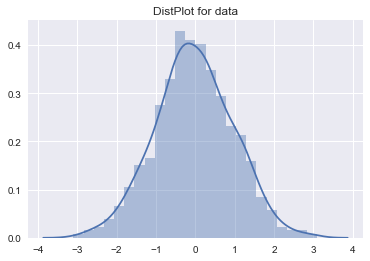

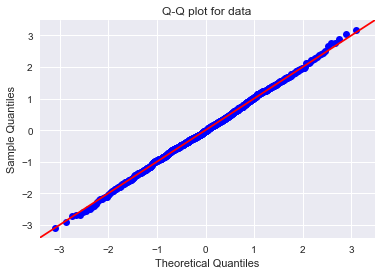

Shapiro-Wilk Test
Accept Ho: Distribution is normal (alpha = 0.05)
P_value:  0.9263656735420227 

D’Agostino’s Test
Accept Ho: Distribution is normal (alpha = 0.05)
P_value:  0.9846850126988143 

Anderson-Darling Test
Statistic: 0.262
15.000: 0.574, Accept Ho: Distribution is normal
10.000: 0.653, Accept Ho: Distribution is normal
5.000: 0.784, Accept Ho: Distribution is normal
2.500: 0.914, Accept Ho: Distribution is normal
1.000: 1.088, Accept Ho: Distribution is normal


In [24]:
normality_test(normal_data)


Data describe 

DescribeResult(nobs=1000, minmax=(0.004514389955981857, 9.99115865395031), mean=5.046354360177358, variance=8.359561525571912, skewness=-0.03273535047944252, kurtosis=-1.1935096352252417) 



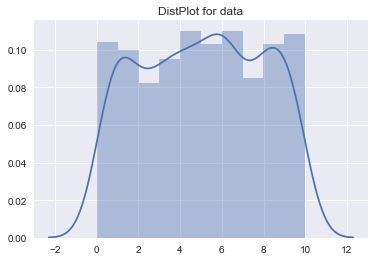

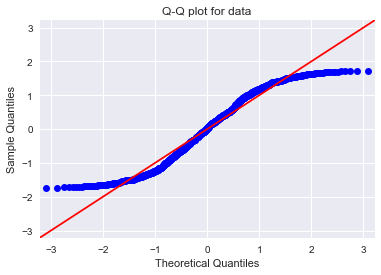

Shapiro-Wilk Test
Reject Ho: Distribution is not normal (alpha = 0.05)
P_value:  2.5899266515774162e-17 

D’Agostino’s Test
Reject Ho: Distribution is not normal (alpha = 0.05)
P_value:  2.175179226394302e-152 

Anderson-Darling Test
Statistic: 11.256
15.000: 0.574, Reject Ho: Distribution is not normal (reject H0)
10.000: 0.653, Reject Ho: Distribution is not normal (reject H0)
5.000: 0.784, Reject Ho: Distribution is not normal (reject H0)
2.500: 0.914, Reject Ho: Distribution is not normal (reject H0)
1.000: 1.088, Reject Ho: Distribution is not normal (reject H0)


In [25]:
normality_test(uniform_data)


Data describe 

DescribeResult(nobs=1000, minmax=(-6.162980988589208, 7.109405608746495), mean=-0.007598392902243724, variance=1.5779694747503836, skewness=0.2050480861929623, kurtosis=3.002499461361041) 



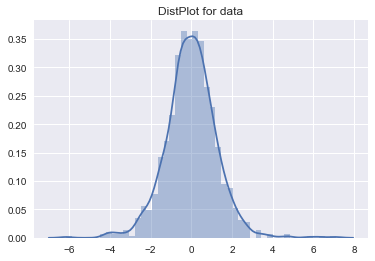

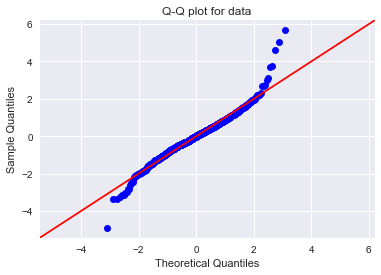

Shapiro-Wilk Test
Reject Ho: Distribution is not normal (alpha = 0.05)
P_value:  4.553513599167558e-13 

D’Agostino’s Test
Reject Ho: Distribution is not normal (alpha = 0.05)
P_value:  1.1416997174913244e-18 

Anderson-Darling Test
Statistic: 3.722
15.000: 0.574, Reject Ho: Distribution is not normal (reject H0)
10.000: 0.653, Reject Ho: Distribution is not normal (reject H0)
5.000: 0.784, Reject Ho: Distribution is not normal (reject H0)
2.500: 0.914, Reject Ho: Distribution is not normal (reject H0)
1.000: 1.088, Reject Ho: Distribution is not normal (reject H0)


In [26]:
df = 6
t_dist_data = np.random.standard_t(df,size = sample_size)
normality_test(t_dist_data)

### HomogenetyTests(equal variances)

Tests equality of variances: F-test, Bartlett's Test, Levene's Test, Squared Ranks Test.


In [27]:
def homogeneity_test(data1,data2, alpha=0.05):
    # Bartlett’s test (equal variances)

    print("Homogenity tests","\n")
    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data1 describe")
    print(describe(data2),"\n")
    print('Bartlett’s test')
    stat, p = bartlett(data1, data2)
    if p > alpha:
        print('Accept Ho: All input samples are from populations with equal variances (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho: All input samples are not from populations with equal variances (alpha = {0})'.format(alpha))
    print('\n')

    # Levene test (equal variances)
    print('Levene’s test')
    stat, p = levene(data1, data2)

    if p > alpha:
        print('Accept Ho: All input samples are from populations with equal variances (alpha = 5%)')
    else:
        print('Reject Ho: All input samples are not from populations with equal variances (alpha = 5%)')
    print('\n')
    print('======================================================================')

In [28]:

np.random.seed(45)

data1 = np.random.normal(10,11,size = sample_size)
data2 = np.random.normal(20,20,size = sample_size)
homogeneity_test(data1,data2)

Homogenity tests 

Data1 describe
DescribeResult(nobs=1000, minmax=(-24.057780751782317, 44.122280665951905), mean=9.666855777615623, variance=118.84495724070712, skewness=0.008366932935316325, kurtosis=0.0036639365763817544) 

Data1 describe
DescribeResult(nobs=1000, minmax=(-36.50450614909508, 90.99333666910155), mean=20.266437246381305, variance=407.3703030071017, skewness=0.012148632541671719, kurtosis=-0.06748325715933401) 

Bartlett’s test
Reject Ho: All input samples are not from populations with equal variances (alpha = 0.05)


Levene’s test
Reject Ho: All input samples are not from populations with equal variances (alpha = 5%)




In [29]:
np.random.seed(45)

data1 = np.random.normal(10,11,size = sample_size)
data2 = np.random.normal(20,11.5,size = sample_size)
homogeneity_test(data1,data2)

Homogenity tests 

Data1 describe
DescribeResult(nobs=1000, minmax=(-24.057780751782317, 44.122280665951905), mean=9.666855777615623, variance=118.84495724070712, skewness=0.008366932935316325, kurtosis=0.0036639365763817544) 

Data1 describe
DescribeResult(nobs=1000, minmax=(-12.49009103572967, 60.82116858473339), mean=20.15320141666925, variance=134.68680643172303, skewness=0.01214863254167128, kurtosis=-0.06748325715933401) 

Bartlett’s test
Reject Ho: All input samples are not from populations with equal variances (alpha = 0.05)


Levene’s test
Accept Ho: All input samples are from populations with equal variances (alpha = 5%)




### Parametric Tests

A parametric test is a hypothesis testing procedure based on the assumption that observed data are distributed according to some distributions of well-known form (e.g., normal, Bernoulli, and so on) up to some unknown parameter(s) on which we want to make inference (say the mean, or the success probability).

#### Student’s t-test

Tests whether the means of two independent samples are significantly different.

In [30]:
def ind_ttest(data1,data2,alpha=0.05):
    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data1 describe")
    print(describe(data2),"\n")
    
    X = np.concatenate((data1.reshape(-1,1),data2.reshape(-1,1)),axis=1)
    sns.boxplot(data = X)
    plt.show()
    print('Inependent T-test')
    stat, p = ttest_ind(data1, data2)

    if p > alpha:
        print('Accept Ho: Input samples are from populations with equal means (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho: Input samples are not from populations with equal means (alpha = {0})'.format(alpha))
    print('\n')
    print('======================================================================')

Data1 describe
DescribeResult(nobs=100, minmax=(-10.968786302570138, 37.48089573181875), mean=13.60820461027183, variance=87.54384036684334, skewness=0.032840043863353006, kurtosis=0.08816203438577697) 

Data1 describe
DescribeResult(nobs=100, minmax=(-14.270364795986524, 39.93633975829063), mean=10.754044681800144, variance=101.26677936079287, skewness=0.0018394821021047111, kurtosis=-0.052408309407002474) 



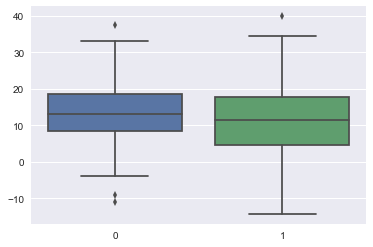

Inependent T-test
Reject Ho: Input samples are not from populations with equal means (alpha = 0.05)




In [31]:
np.random.seed(45)
sample_size = 100
data1 = np.random.normal(15,10,size = sample_size)
data2 = np.random.normal(10,10,size = sample_size)
ind_ttest(data1,data2,alpha = 0.05)

#### Paired Student’s t-test (not independent)

Tests whether the means of two paired samples are significantly different.

In [32]:
def rel_indtest(data1,data2,alpha=0.05):
    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data1 describe")
    print(describe(data2),"\n")
    
    X = np.concatenate((data1.reshape(-1,1),data2.reshape(-1,1)),axis=1)
    sns.boxplot(data = X)
    plt.show()
    print('Inependent T-test')
    stat, p = ttest_rel(data1, data2)

    if p > alpha:
        print('Accept Ho: Input samples are from populations with equal means (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho: Input samples are not from populations with equal means (alpha = {0})'.format(alpha))
    print('\n')
    print('======================================================================')

Data1 describe
DescribeResult(nobs=100, minmax=(38.32979647974259, 65.51012757543268), mean=50.92759850422245, variance=25.125602327503707, skewness=0.05480714412842982, kurtosis=-0.03410172934748834) 

Data1 describe
DescribeResult(nobs=100, minmax=(37.48217522578545, 64.08471195011145), mean=50.24919069766557, variance=23.206712387834113, skewness=0.2197568220145254, kurtosis=0.20626734871214047) 



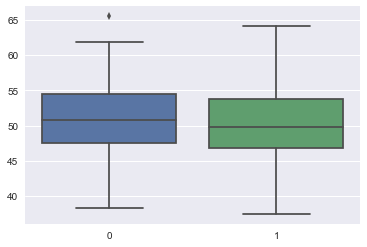

Inependent T-test
Accept Ho: Input samples are from populations with equal means (alpha = 0.05)




In [33]:
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 51
rel_indtest(data1,data2)

#### Analysis of Variance Test (ANOVA)

Tests whether the means of two or more independent samples are significantly different.

In [34]:
def anova_test(data1,data2,data3,alpha=0.05):

    # anova test (equal means)
    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data1 describe")
    print(describe(data2),"\n")
    
    X = np.concatenate((data1.reshape(-1,1),data2.reshape(-1,1),data3.reshape(-1,1)),axis=1)
    sns.boxplot(data = X)
    plt.show()
    
    print("\n")

    print('ANOVA test')
    stat, p = f_oneway(data1, data2, data3)

    if p > alpha:
        print('Accept Ho: Input samples are from populations with equal means (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho: Input samples are not from populations with equal means (alpha = {0})'.format(alpha))
    print('\n')
    print('======================================================================')

Data1 describe
DescribeResult(nobs=100, minmax=(-10.968786302570138, 37.48089573181875), mean=13.60820461027183, variance=87.54384036684334, skewness=0.032840043863353006, kurtosis=0.08816203438577697) 

Data1 describe
DescribeResult(nobs=100, minmax=(-9.270364795986524, 44.93633975829063), mean=15.754044681800146, variance=101.26677936079287, skewness=0.0018394821021044416, kurtosis=-0.052408309407002474) 



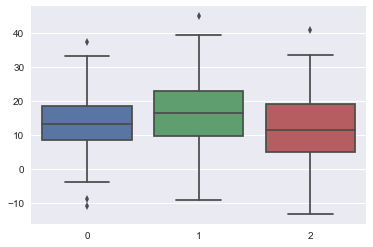



ANOVA test
Reject Ho: Input samples are not from populations with equal means (alpha = 0.05)




In [35]:
np.random.seed(45)
sample_size = 100
data1 = np.random.normal(15,10,size = sample_size)
data2 = np.random.normal(15,10,size = sample_size)
data3 = np.random.normal(10,10,size = sample_size)
anova_test(data1,data2,data3)

### Non-parametric tests

Non-parametric tests are “distribution-free” and, as such, can be used for non-Normal variables, But Parametric tests usually have more statistical power than their non-parametric equivalents. In other words, one is more likely to detect significant differences when
they truly exist.


#### Mann-Whitney U Test

Tests whether the distributions of two independent samples are equal or not.

In [36]:
def mann_whitney(data1,data2,alpha=0.05):
    # MannWhitney test for two independent samples (equal means)

    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data1 describe")
    print(describe(data2),"\n")
    sns.distplot(data1).set_title("data1")
    plt.show()
    sns.distplot(data2).set_title("data2")
    plt.show()
    
    print('Mann-Whitney test')
    stat, p = mannwhitneyu(data1, data2)

    if p > alpha:
        print('Accept Ho:  The distributions of both samples are equal. (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho:  the distributions of both samples are not equal. (alpha = {0})'.format(alpha))
    print('\n')

Data1 describe
DescribeResult(nobs=100, minmax=(36.48217522578545, 63.084711950111455), mean=49.24919069766557, variance=23.206712387834113, skewness=0.2197568220145254, kurtosis=0.20626734871214047) 

Data1 describe
DescribeResult(nobs=100, minmax=(34.51919056737167, 63.556969094908595), mean=49.52038917215003, variance=25.89684101270147, skewness=0.0694411544952896, kurtosis=0.04181030064003233) 



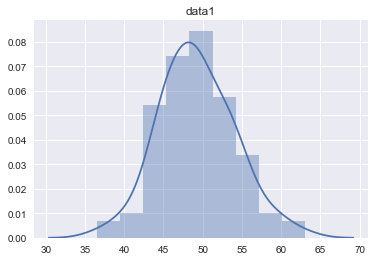

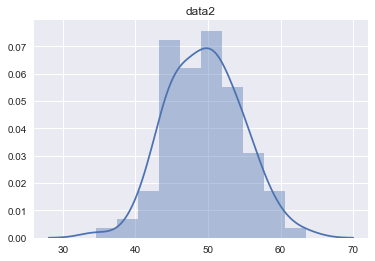

Mann-Whitney test
Accept Ho:  The distributions of both samples are equal. (alpha = 0.05)




In [37]:
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 50
mann_whitney(data1,data2)

Data1 describe
DescribeResult(nobs=100, minmax=(36.61241742098819, 59.40049984277293), mean=49.84908739385836, variance=19.985297310229726, skewness=-0.09036938455004231, kurtosis=0.048505891893552366) 

Data1 describe
DescribeResult(nobs=100, minmax=(36.48009703202809, 61.96893663667492), mean=50.48188053109168, variance=26.312621688048285, skewness=-0.25966847804137233, kurtosis=-0.14444307540664836) 



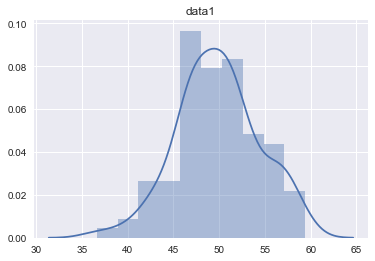

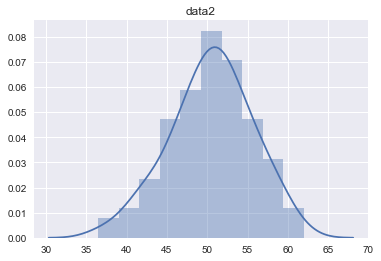

Mann-Whitney test
Accept Ho:  The distributions of both samples are equal. (alpha = 0.05)




In [38]:
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 51
mann_whitney(data1,data2)


#### Wilcoxon Signed-Rank Test

Tests whether the distributions of two paired samples are equal or not.

In [39]:
def WilcoxonRankSum(data1,data2, alpha=0.05):
    # Wilcoxon Rank-Sum test for two independent samples (equal means)
    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data1 describe")
    print(describe(data2),"\n")
    sns.distplot(data1).set_title("data1")
    plt.show()
    sns.distplot(data2).set_title("data2")
    plt.show()
    
    print('WilcoxonRankSum')
    stat, p = ranksums(data1, data2)
    if p > alpha:
        print('Accept Ho:  The distributions of both samples are equal. (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho:  the distributions of both samples are not equal. (alpha = {0})'.format(alpha))
    print('\n')

Data1 describe
DescribeResult(nobs=100, minmax=(36.465675268978536, 61.97599257565818), mean=50.15126280470664, variance=28.065412146961734, skewness=-0.2335255428627041, kurtosis=-0.34549071545516075) 

Data1 describe
DescribeResult(nobs=100, minmax=(37.16220189157398, 64.1749134841609), mean=49.75945081180707, variance=27.012291140052184, skewness=0.300210412229507, kurtosis=0.23111593870673586) 



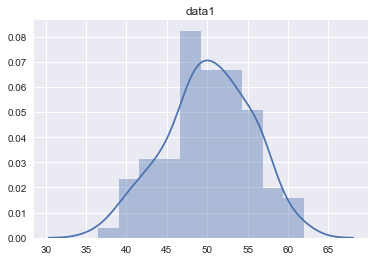

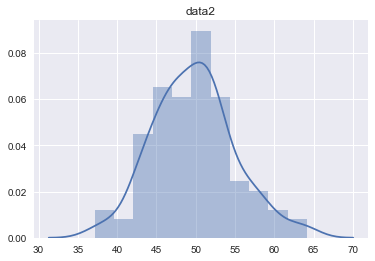

WilcoxonRankSum
Accept Ho:  The distributions of both samples are equal. (alpha = 0.05)




In [40]:
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 50
WilcoxonRankSum(data1,data2)


Data1 describe
DescribeResult(nobs=100, minmax=(37.49232539744953, 61.14330875219242), mean=49.86572351853323, variance=22.506300769770252, skewness=-0.07712355308232847, kurtosis=-0.08267077894235797) 

Data1 describe
DescribeResult(nobs=100, minmax=(44.39481458974303, 69.0138240865612), mean=55.395179755576365, variance=19.705659043972922, skewness=0.15770436465675566, kurtosis=0.7692991438424484) 



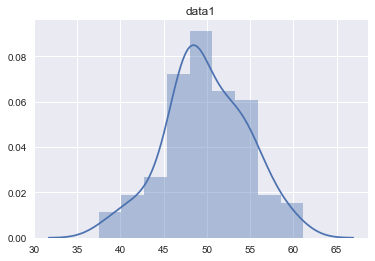

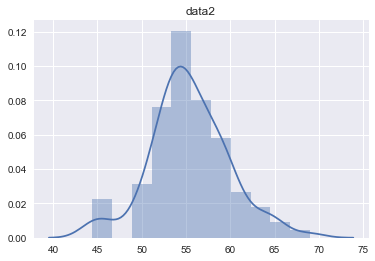

WilcoxonRankSum
Reject Ho:  the distributions of both samples are not equal. (alpha = 0.05)




In [41]:
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 55
WilcoxonRankSum(data1,data2)

### Kruskal-Wallis H Test

Tests whether the distributions of two or more independent samples are equal or not.

In [43]:
def kruskal_wallis_h_test(data1,data2,data3, alpha=0.05):
    # Kruskal-Wallis H-test for independent samples (non-parametric version of ANOVA)
    print("Data1 describe")
    print(describe(data1),"\n")
    print("Data2 describe")
    print(describe(data2),"\n")
    print("Data3 describe")
    print(describe(data3),"\n")
    
    sns.distplot(data1).set_title("data1")
    plt.show()
    sns.distplot(data2).set_title("data2")
    plt.show()
    sns.distplot(data3).set_title("data2")
    plt.show()

    print('Kruskal-Wallis H-test')
    stat, p = kruskal(data1, data2, data3)

    if p > alpha:
        print('Accept Ho:  The distributions of both samples are equal. (alpha = {0})'.format(alpha))
    else:
        print('Reject Ho:  the distributions of both samples are not equal. (alpha = {0})'.format(alpha))
    print('\n')

Data1 describe
DescribeResult(nobs=100, minmax=(39.50145779152124, 62.05047132006081), mean=50.247268137545596, variance=25.249918543631054, skewness=-0.06910705164480604, kurtosis=-0.3245370110697401) 

Data2 describe
DescribeResult(nobs=100, minmax=(39.443554393098324, 65.18751136514337), mean=52.89629072454468, variance=32.11975370057592, skewness=0.02820106342423897, kurtosis=-0.7430267901294529) 

Data3 describe
DescribeResult(nobs=100, minmax=(38.53387296008, 63.212842723960776), mean=50.07112877680127, variance=28.36164364350372, skewness=-0.09223272430488334, kurtosis=-0.4573275251370785) 



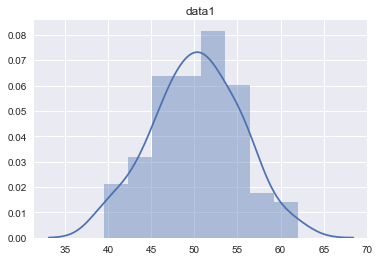

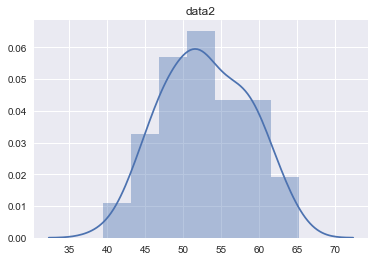

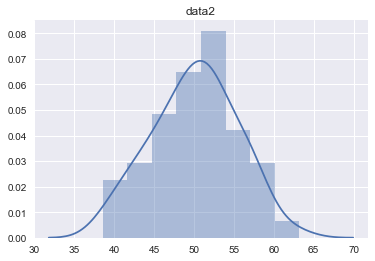

Kruskal-Wallis H-test
Reject Ho:  the distributions of both samples are not equal. (alpha = 0.05)




In [44]:
data1 = 5 * np.random.randn(100) + 50
data2 = 5 * np.random.randn(100) + 53
data3 = 5 * np.random.randn(100) + 50

kruskal_wallis_h_test(data1,data2,data3)